# Explore Library Usage

This is an exploratory Analysis with the goal of understanding the data more in-depth.

Assumptions: 
- There are no incorrect values

In [51]:
#import and read in data

import pandas as pd 
import numpy as np
import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
sb.set_style('whitegrid')
fig = plt.figure()

data = pd.read_csv('C:/Users/Scott/Desktop/Data/Library_Usage.csv')


#Briefly look at data
data.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


- Patron Type Code-----------------Nominal
- Patron Type Definition-----------Nominal
- Total Checkouts------------------Numeric
- Total Renewals-------------------Numeric
- Age Range------------------------Nominal
- Home Library Code----------------Nominal
- Home Library Definition----------Nominal
- Circulation Active Month---------Nominal
- Circulation Active Year----------Nominal
- Notice Preference Code-----------Nominal
- Notice Preference Definition-----Nominal
- Provided Email Address-----------Binary
- Year Patron Registered-----------Numeric
- Outside of County----------------Binary
- Supervisor District--------------(empty)

# Clean

### Duplicates Columns
- Patron Type Code & Patron Type Definition
- Home Library Code & Home Library Definition
- Notice Preference Code & Notice Preference Definition

In [197]:
df = data
df = df.drop('Patron Type Code',1)
df = df.drop('Home Library Code',1)
df = df.drop('Notice Preference Code',1)

### Remove Nulls

In [198]:
print(df.isnull().sum())
df = df.drop('Supervisor District',1)
df = df.dropna(axis=0)

Patron Type Definition               0
Total Checkouts                      0
Total Renewals                       0
Age Range                          215
Home Library Definition              0
Circulation Active Month             0
Circulation Active Year              0
Notice Preference Definition         0
Provided Email Address               0
Year Patron Registered               0
Outside of County                    0
Supervisor District             110310
dtype: int64


# Explore

#### Table of Contents
1. View 2 continuous variables
2. View all categorical variables
3. Determine intial segmentation
4. Test to see if segmenting is valid
5. Redo until segment works
6. Conclusion

## View 2 continuous variables

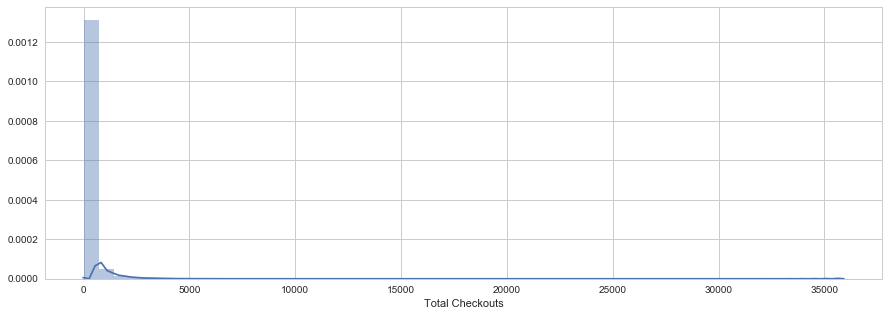

In [199]:
plt.figure(figsize=(15,5))
sb.distplot(df['Total Checkouts'])

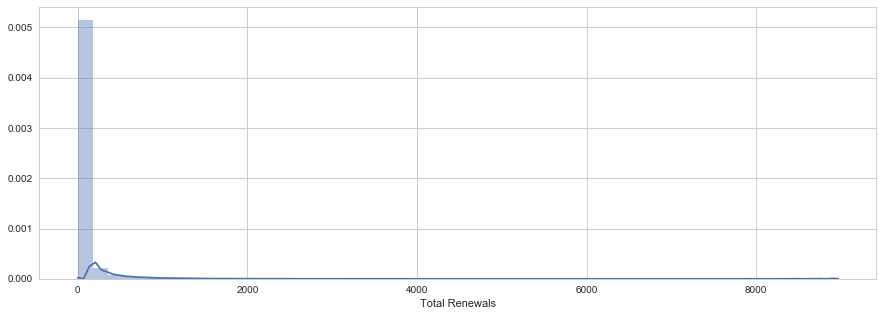

In [200]:
plt.figure(figsize=(15,5))
sb.distplot(df['Total Renewals'])

We now the data here is really skewed for both continuous variables. Let's normal it by taking the log of them.

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticks'

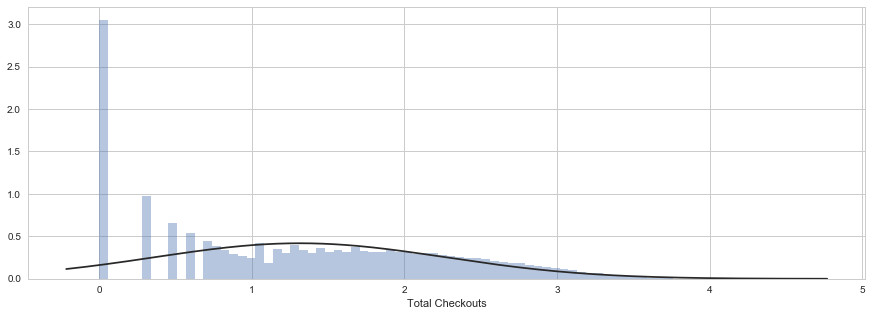

In [231]:
from scipy.stats import norm
x = df['Total Checkouts'] + 1
x = np.log10(x)

plt.figure(figsize=(15,5))

sb.distplot(x,bins=80,fit=norm,kde=False)
xticks = [0,10,100,1000,10000]
plt.set_xticks(xticks)
plt.set_xticklabels(xticks, fontsize=16)

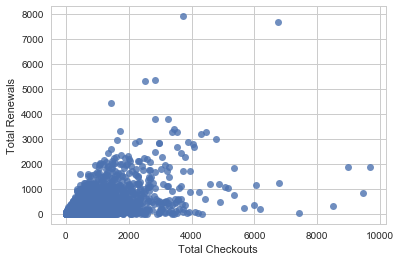

In [202]:
#Since there are 420k records lets take a small sample of the total population...let's say 5%
df_sample = df.sample(frac=.05)
sb.regplot(df_sample['Total Checkouts'],df_sample['Total Renewals'], fit_reg=False)

We see that almost all of the observations are with in 2000 renewal range and the 4000 checkout range. There looks to be quite a few outliers that may need to be removed. Also I need to transform these variables because they are really skewed. 

### Let's look at all the defining attributes of the population's library activity 
1. Patron Type
2. Age Range
3. Library Location
4. Last Active Year
5. Preferred Notification medium

As we look at these attributes, I will slice up the activity volume to:

1. All activity
2. Low activity
3. High activity
4. Outlying activity. 

This will hopefully help me see if there are any differentiating signs from the 3 slices.

    - High Activities will be > mean
    - Low Activities will be < mean
    - Outliers will be > 90th percentile 
    
    
*WARNING* to save space I did NOT keep all the graphs at the same limits. Please be aware of the axis increments! ***

In [56]:
# Finding Mean and 90% numbers
# Slicing DF accordingly
med = np.mean(df['Total Checkouts'])
mid = np.mean(df['Total Renewals'])

outlier_q3c = df['Total Checkouts'].quantile(.9)
outlier_q3r = df['Total Renewals'].quantile(.9)

low_df_slice = df.loc[df['Total Checkouts'] < med]
low_df_slice = low_df_slice.loc[low_df_slice['Total Renewals'] < mid]

high_df_slice = df.loc[df['Total Checkouts'] > med]
high_df_slice = high_df_slice.loc[high_df_slice['Total Checkouts'] < outlier_q3c]
high_df_slice = high_df_slice.loc[high_df_slice['Total Renewals'] > mid]
high_df_slice = high_df_slice.loc[high_df_slice['Total Renewals'] < outlier_q3r]

outlier_df_slice = df.loc[df['Total Checkouts'] > outlier_q3c]
outlier_df_slice = outlier_df_slice.loc[outlier_df_slice['Total Renewals'] > outlier_q3r]

#### Patron Type

C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


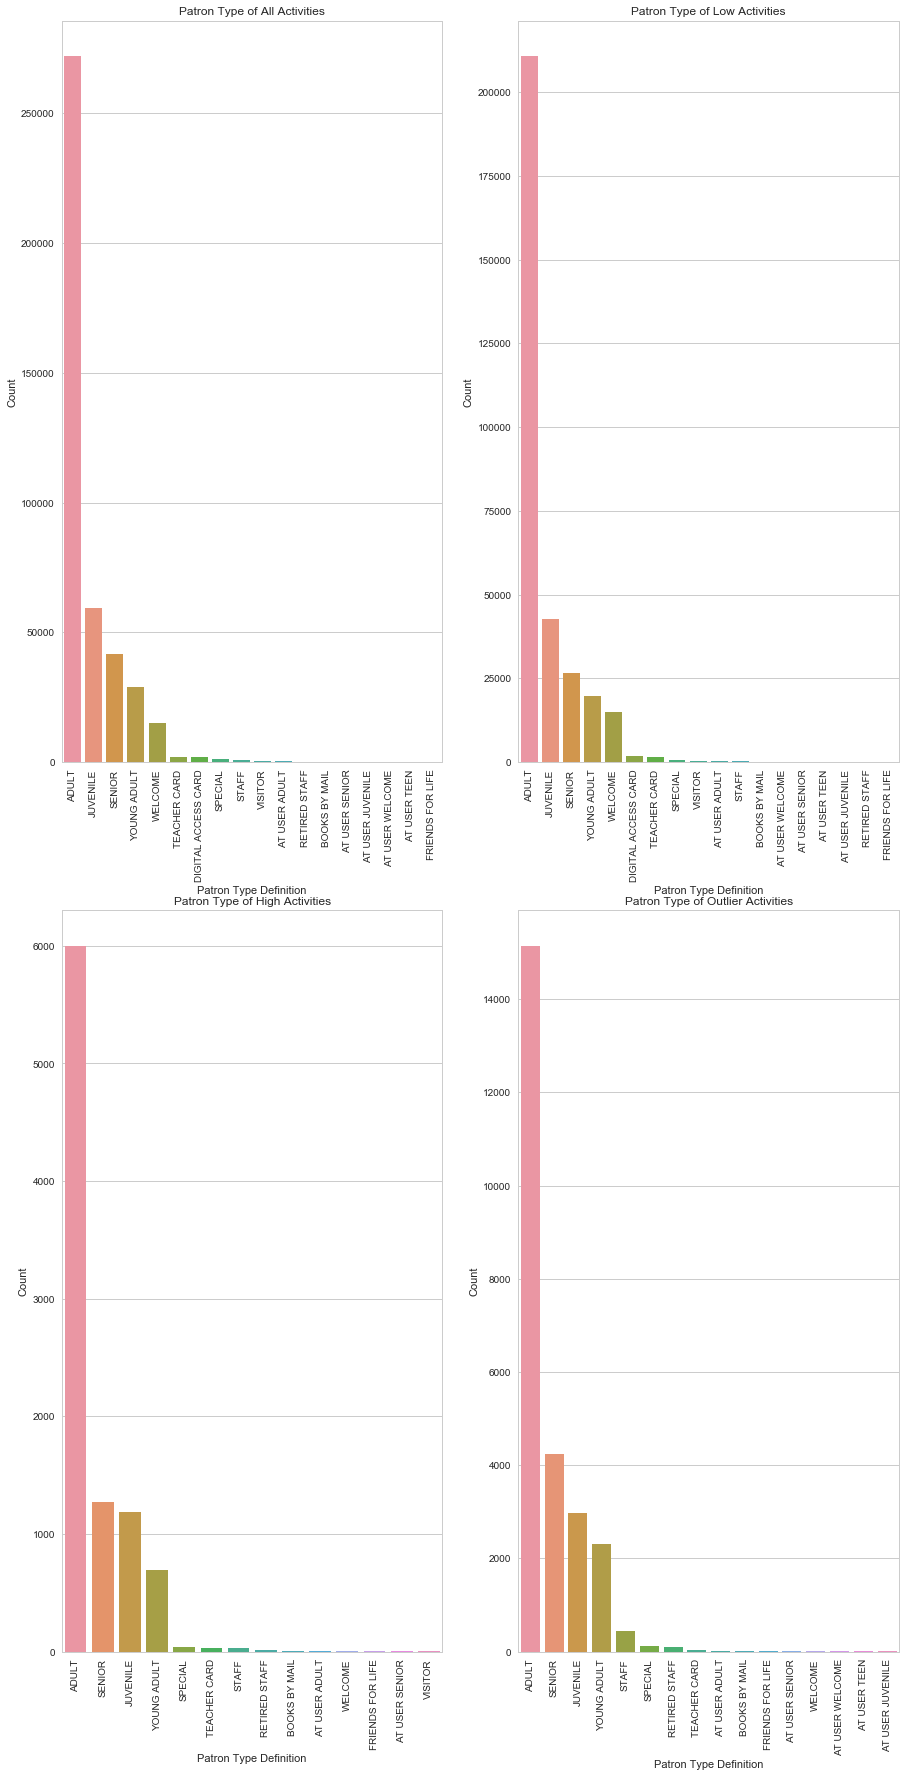

In [57]:
from matplotlib.gridspec import GridSpec
the_grid = GridSpec(2, 2)
plt.figure(figsize=(15,30))

# All activity Patron Type
plt.subplot(the_grid[0,0])
allgrouping = df.groupby('Patron Type Definition')
num = allgrouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Patron Type of All Activities')
plt.xticks(rotation= 90)

# Low Activity Patron Type
plt.subplot(the_grid[0,1])
grouping = low_df_slice.groupby('Patron Type Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Patron Type of Low Activities')
plt.xticks(rotation= 90)

# High Activity Patron Type
plt.subplot(the_grid[1,0])
grouping = high_df_slice.groupby('Patron Type Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Patron Type of High Activities')
plt.xticks(rotation= 90)

# Outlier Activity Patron Type
plt.subplot(the_grid[1,1])
grouping = outlier_df_slice.groupby('Patron Type Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Patron Type of Outlier Activities')
plt.xticks(rotation= 90)

plt.show()

These graph show very little change between the different slices. In fact this attribute may be worth throwing away because of its inconsistent categories.

#### Age Range

C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


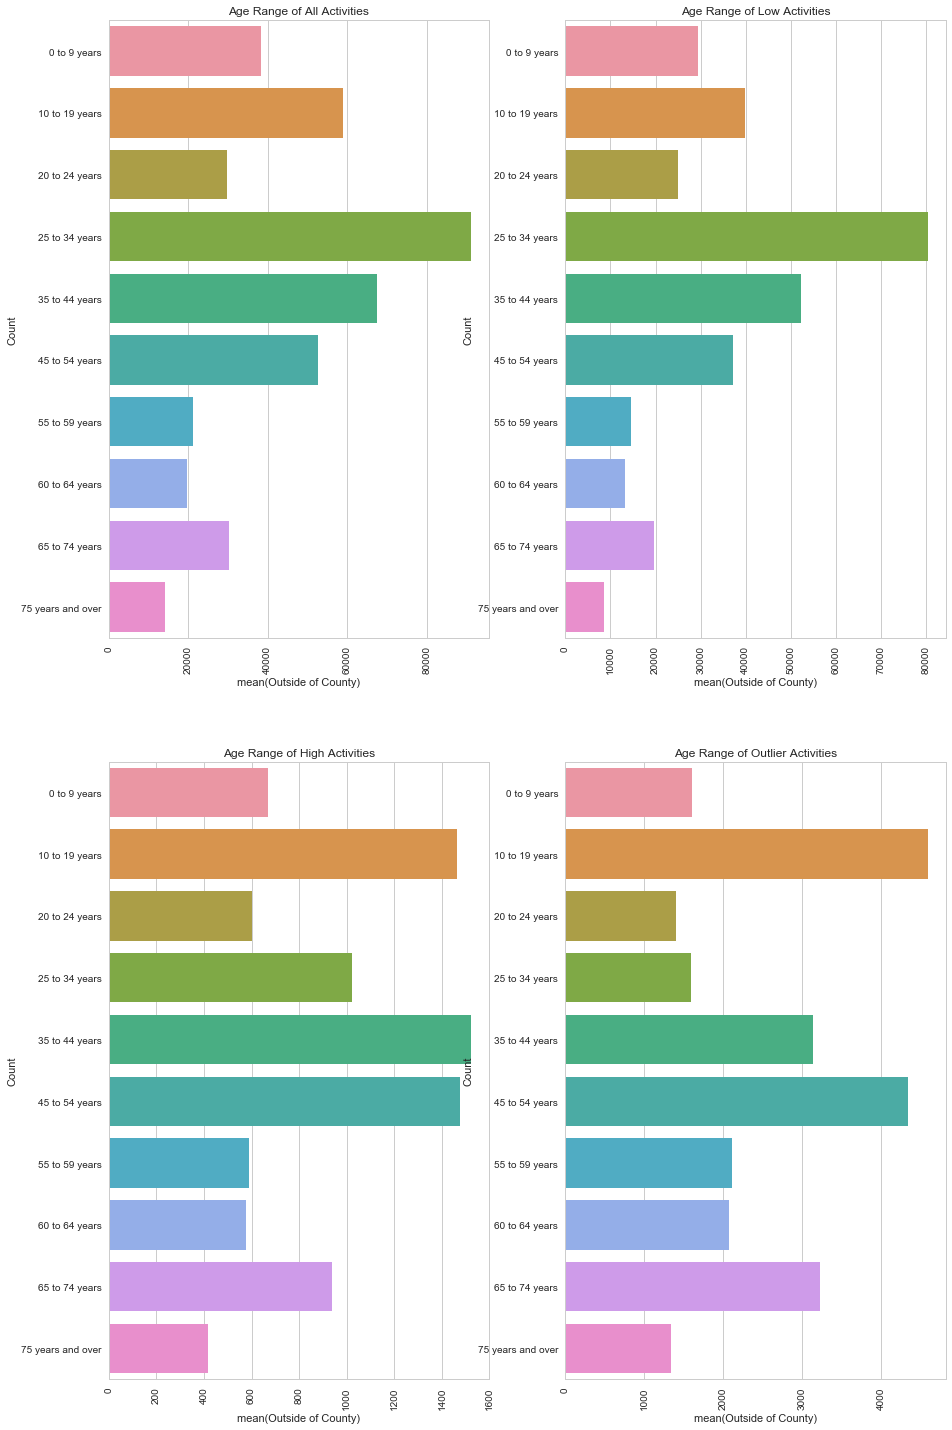

In [58]:
# All activity Age Range
plt.figure(figsize=(15,25))
plt.subplot(the_grid[0,0])
allgrouping = df.groupby('Age Range')
num = allgrouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Age Range of All Activities')
plt.xticks(rotation= 90)

# Low Activity Age Range
plt.subplot(the_grid[0,1])
grouping = low_df_slice.groupby('Age Range')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Age Range of Low Activities')
plt.xticks(rotation= 90)


# High Activity Age Range
plt.subplot(the_grid[1,0])
grouping = high_df_slice.groupby('Age Range')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Age Range of High Activities')
plt.xticks(rotation= 90)

# Outlier Activity Age Range
plt.subplot(the_grid[1,1])
grouping = outlier_df_slice.groupby('Age Range')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Age Range of Outlier Activities')
plt.xticks(rotation= 90)

plt.show()

These graphs show more promise. Age could very well be the best classifier for cohorts. Additionally, it seems there may be some trends with age groups and their amount of activity. For example, High active users seem to be more evenly distributed 3 distinct steps:
- top range
    - 35-44
    - 45-54
    - 10-19
- mid range
    - 25-34
    - 65-74
- low range
    - 0-9
    - 20-24
    - 55-59
    - 60-64
    - 75 and older

While the All slice and Low slice show a steady decline from the first range down to the last range. This may be worth looking into more.

#### Last Active Year

C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


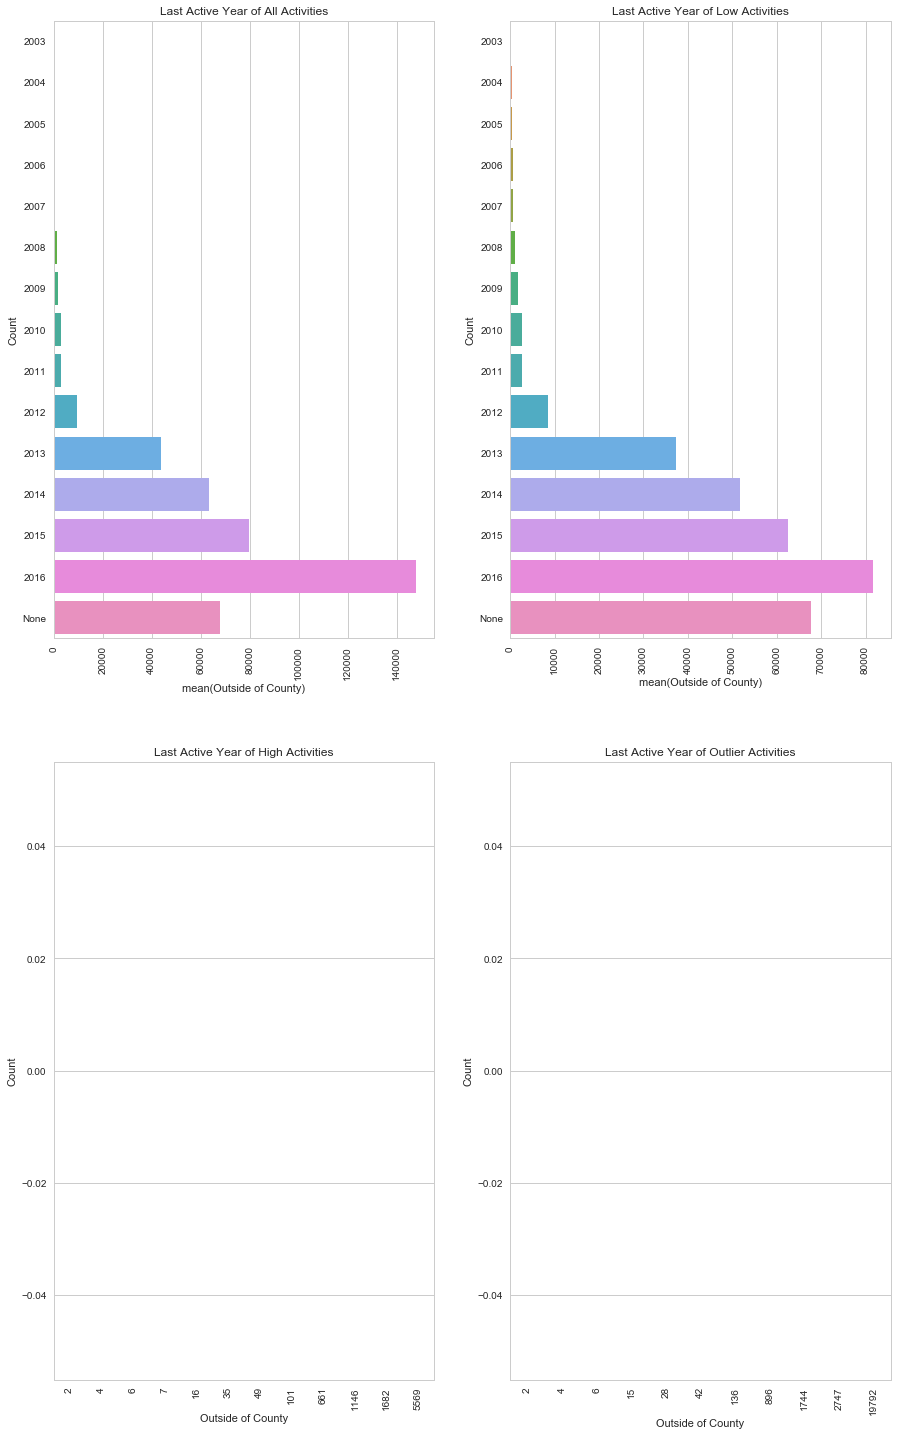

In [59]:
plt.figure(figsize=(15,25))
# All activity Last Active Year
plt.subplot(the_grid[0,0])
allgrouping = df.groupby('Circulation Active Year')
num = allgrouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Last Active Year of All Activities')
plt.xticks(rotation= 90)

# Low Activity Last Active Year
plt.subplot(the_grid[0,1])
grouping = low_df_slice.groupby('Circulation Active Year')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Last Active Year of Low Activities')
plt.xticks(rotation= 90)


# High Activity Last Active Year
plt.subplot(the_grid[1,0])
grouping = high_df_slice.groupby('Circulation Active Year')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Last Active Year of High Activities')
plt.xticks(rotation= 90)

# Outlier Activity Last Active Year
plt.subplot(the_grid[1,1])
grouping = outlier_df_slice.groupby('Circulation Active Year')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Last Active Year of Outlier Activities')
plt.xticks(rotation= 90)

plt.show()

Low Active as a considerable variation in last uses. This makes sense because people that have only gone to the library a hand full of times would be considered low active. While people with high or oulying active rates would need to be still going to the library to get such high activity rates.

#### Library Location

C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


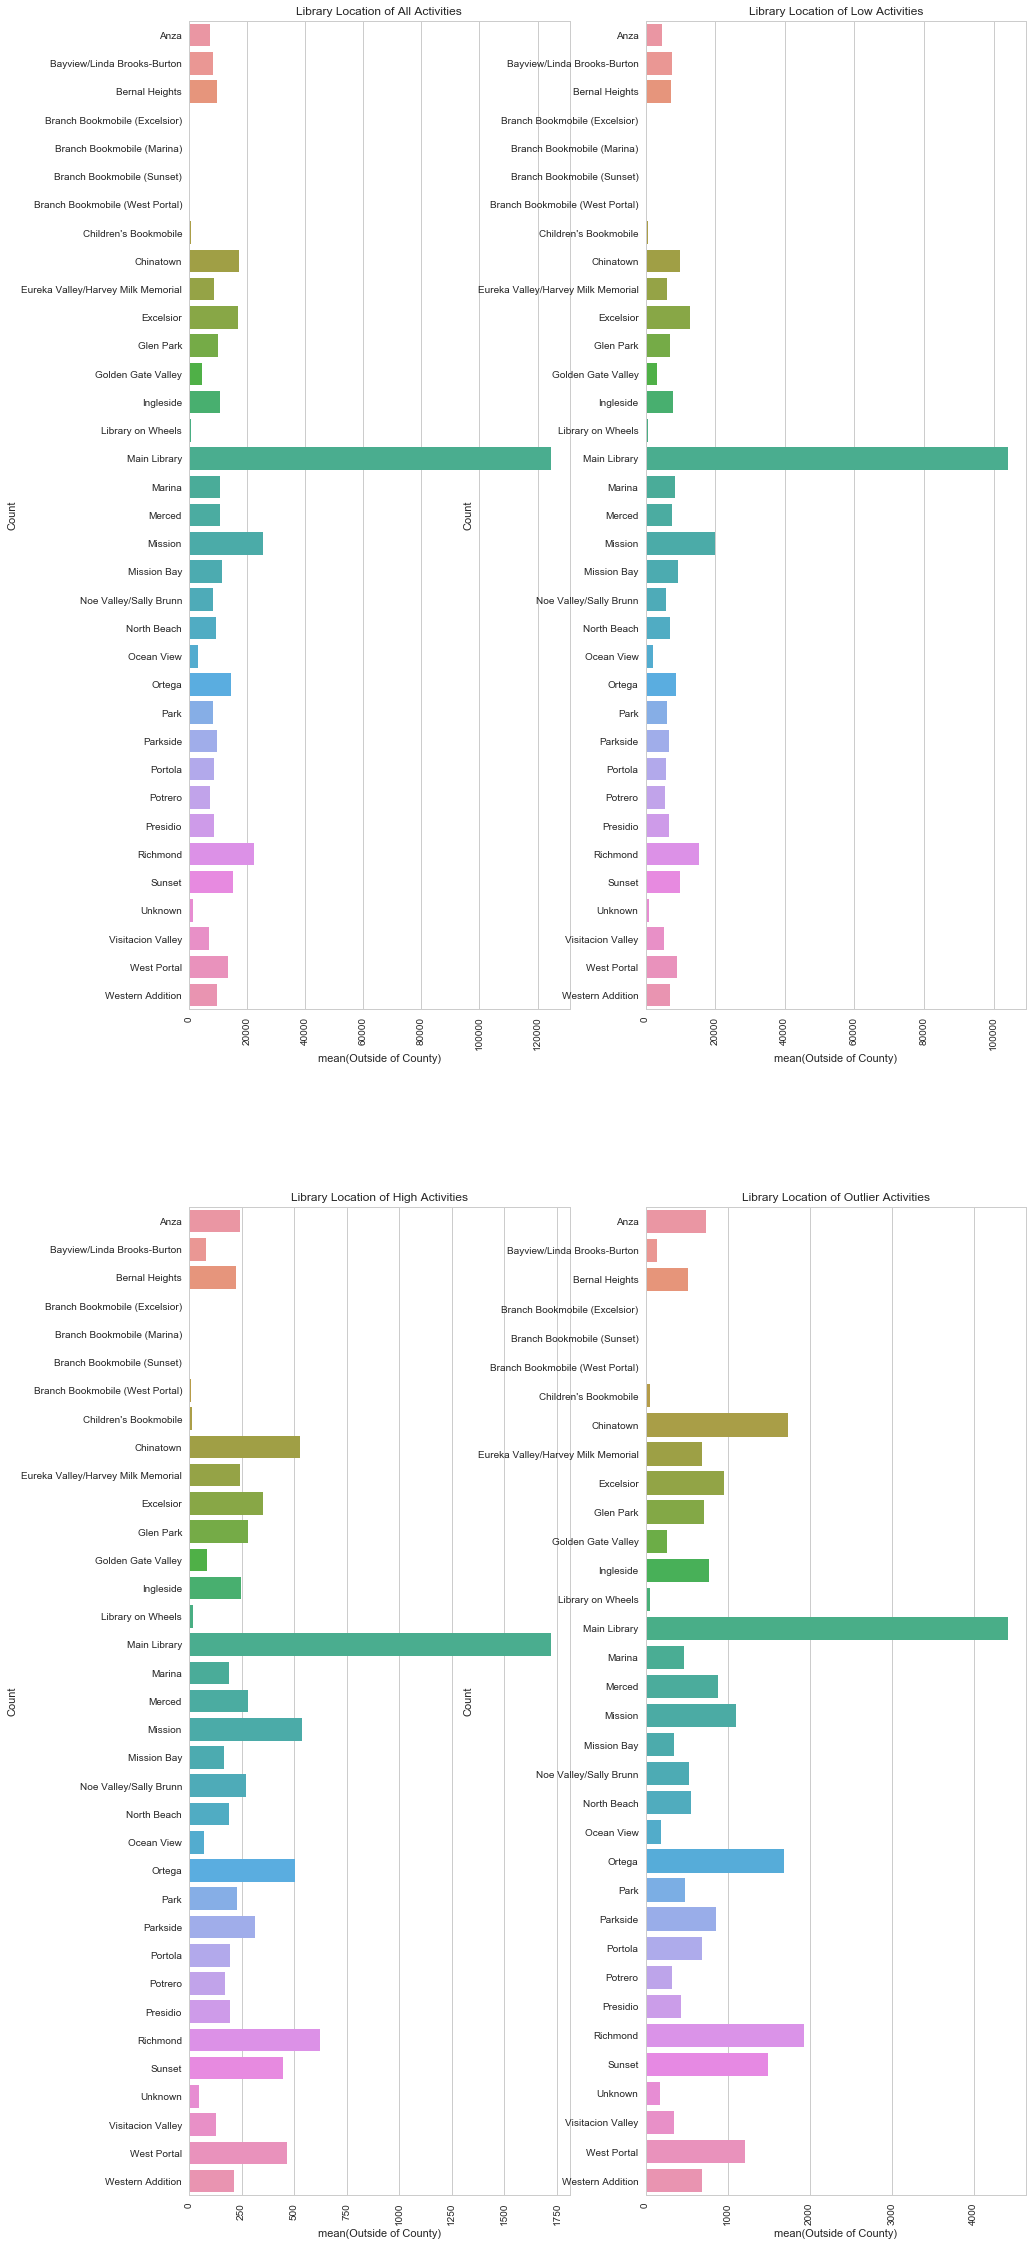

In [60]:
plt.figure(figsize=(15,40))
# All activity Library Location
plt.subplot(the_grid[0,0])
allgrouping = df.groupby('Home Library Definition')
num = allgrouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Library Location of All Activities')
plt.xticks(rotation= 90)

# Low Activity Home Library Definition
plt.subplot(the_grid[0,1])
grouping = low_df_slice.groupby('Home Library Definition')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Library Location of Low Activities')
plt.xticks(rotation= 90)


# High ActivityHome Library Definition
plt.subplot(the_grid[1,0])
grouping = high_df_slice.groupby('Home Library Definition')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Library Location of High Activities')
plt.xticks(rotation= 90)

# Outlier Activity Home Library Definition
plt.subplot(the_grid[1,1])
grouping = outlier_df_slice.groupby('Home Library Definition')
num = grouping['Outside of County'].count()
ax = sb.barplot(x=num,y=num.index)
plt.ylabel('Count')
plt.title('Library Location of Outlier Activities')
plt.xticks(rotation= 90)

plt.show()

Library location doesn't look very interesting in this brief glance. But I'm sure we could find something interesting by diving into the slices at each location.

#### Preferred Notification Medium

C:\Users\Scott\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


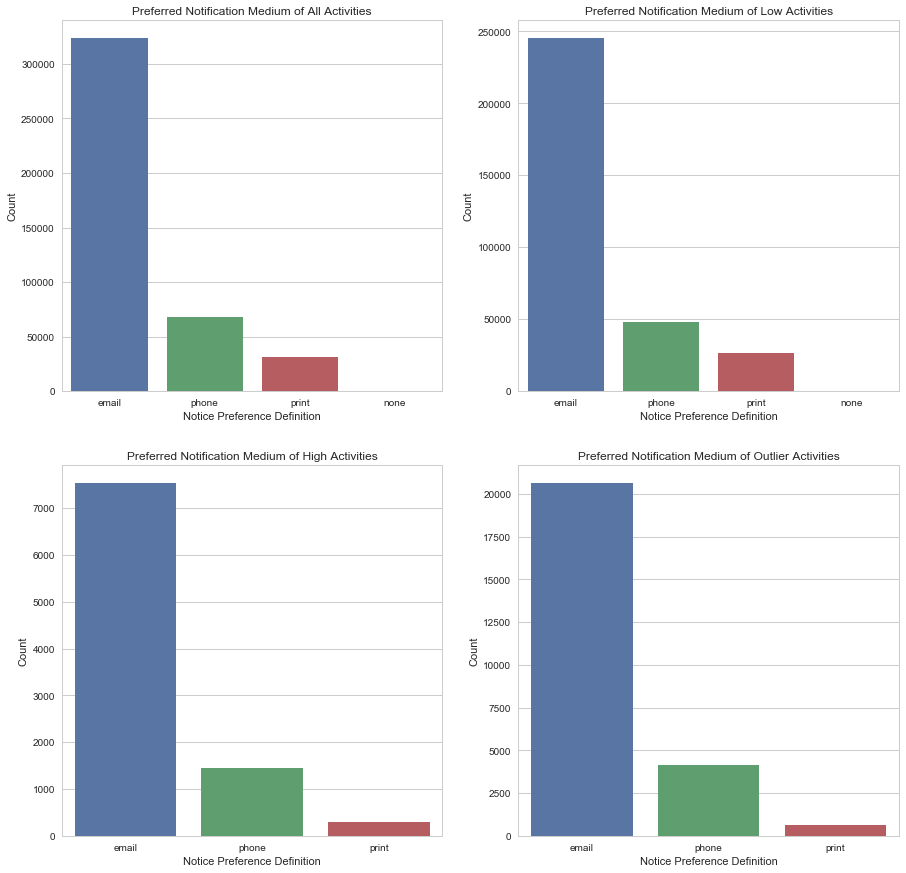

In [61]:
plt.figure(figsize=(15,15))
# All activity Preferred Notification Medium
plt.subplot(the_grid[0,0])
allgrouping = df.groupby('Notice Preference Definition')
num = allgrouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Preferred Notification Medium of All Activities')


# Low Activity Preferred Notification Medium
plt.subplot(the_grid[0,1])
grouping = low_df_slice.groupby('Notice Preference Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Preferred Notification Medium of Low Activities')


# High Activity Preferred Notification Medium
plt.subplot(the_grid[1,0])
grouping = high_df_slice.groupby('Notice Preference Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Preferred Notification Medium of High Activities')

# Outlier Activity Preferred Notification Medium
plt.subplot(the_grid[1,1])
grouping = outlier_df_slice.groupby('Notice Preference Definition')
num = grouping['Outside of County'].count().sort_values(ascending=False)
ax = sb.barplot(x=num.index,y=num)
plt.ylabel('Count')
plt.title('Preferred Notification Medium of Outlier Activities')


plt.show()

These graph may be a good predictor for finding the older generations activity levels. Since most people use email for notifications, it would be a clear sign of age if someone preferred a postcard or printable activity rates. 

This slicing approach works well for the assumption that the cohorts(groups) are marketing segments. For example it helps establish which "age range" is active this year with x volume of activity. These groups can be very distinguishable with the correct data mining. Yet, Even with my light weight analysis it can be observed that there are trends. 

#### Some small immediate insights
- "Age Range" changes the most over the 3 different slices. This will most likely be the most important attribute. And should be considered the main classifier.
- "Patron Type" is a strange chaotic attribute and might be worth dropping.
- Slicing by "Notice Preference" and "Library Location" may be very helpful attributes as a secondary field. 
- The Outlier Activity group seems to use the library more frequently than the other slices. Also, the portion of outliers with "last active year" of 2016 is very high. This makes sense because people that have very high renewals and checkouts must be consistly using the library.

### Conclusion
- Unfortuntely, other than small differences, there isn't anything conclusive. With more time I would go deeper with the slices! Once these slices were finished, other avenues should be looked at. One way of doing this is doing a KMeans Clustering model to find hidden clustering patterns. Another option is to do a RandomForest Model which will classify cohorts by itself.
 